# 3.3 Classificador de dígitos completo

Para construir um classificador para os quatro dígitos contidos na base, utiliza-se a estratégia **"Um Contra Todos"**.

## Passo a Passo

1. **Escolha de um dígito positivo**  
   Inicialmente, escolhe-se um dígito específico (por exemplo, **0**) para ser a classe **𝑦 = +1**.

2. **Agrupamento dos demais dígitos**  
   Todos os outros dígitos (por exemplo, **1, 4 e 5**) são temporariamente definidos como a classe **𝑦 = −1**.

3. **Treinamento do modelo**  
   O modelo é treinado para distinguir o dígito escolhido (**positivo**) de todos os outros (**negativos**).

4. **Repetição para cada dígito**  
   O processo é repetido para cada dígito que se deseja classificar. Assim, teremos um classificador separado para cada número.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

In [11]:
warnings.filterwarnings("ignore")

## Por que criar duas funções para “Um Contra Todos”?

No projeto de classificação dos dígitos usando a estratégia **“Um Contra Todos”**, precisou-se criar duas funções separadas devido às diferenças fundamentais entre os modelos utilizados: **Regressão Linear** versus **Perceptron / Regressão Logística**.

---

## Regressão Linear

- **Saída do modelo:** valores contínuos (float), que podem assumir qualquer valor real.
- **Problema:** não fornece diretamente classes discretas (+1/-1).
- **Solução:** aplicar um **limiar (threshold)** para converter a saída contínua em classe binária


##  Perceptron e Regressão Logística

- **Saída do modelo:** classes discretas (+1 ou -1) diretamente.

- **Vantagem:** não precisa de threshold, pois o próprio predict() retorna a decisão binária.

In [ ]:
def treinar_um_contra_todos(classificador, X_train, y_train, X_test, y_test, digitos_alvo=[0, 1, 4]):
    """
    Treina classificadores no esquema Um-Contra-Todos (One-vs-All)
    para os dígitos 0, 1 e 4. Retorna os classificadores e previsões.
    """
    classificadores = {}

    for idx, digito in enumerate(digitos_alvo):
        y_bin = np.where(y_train == digito, 1, -1)
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        clf = classificador()
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    return classificadores

In [13]:
def previsoes(classificador, X_test, y_test, classificadores):
        # Predição
    previsoes = []
    for x in X_test:
        pred = None
        
        if classificador == LinearRegression:
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                y_cont = clf.predict(x_scaled)[0]
                if y_cont >= 0:
                    pred = digito
                    break
        else:
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if clf.predict(x_scaled)[0] == 1:
                    pred = digito
                    break
                
        if pred is None:
            pred = 5
        previsoes.append(pred)

    print(f"\nModelo: {classificador.__name__}")
    print(classification_report(y_test, previsoes, digits=2))
    
    return classificadores, previsoes

# 3.4 Funçoes de plotagem

In [23]:
def plot_um_contra_todos(classificadores, X, y, digitos_alvo=[0,1,4], modo="fronteira"):
    """
    Plota fronteiras e opcionalmente regiões de decisão
    para classificadores One-vs-All.

    Parâmetros
    ----------
    classificadores : dict
        {digito: (modelo, scaler)}
    X : np.array
        Dados de entrada (features)
    y : np.array
        Rótulos verdadeiros
    digitos_alvo : list
        Quais dígitos são alvo no treinamento
    modo : str
        "fronteira" -> só as linhas de decisão
        "regioes"   -> regiões + linhas
    """

    # Cores para os pontos e linhas
    cores_pontos = {0:'orange', 1:'blue', 4:'green', 5:'red'}
    cores_linhas = {0:'red', 1:'blue', 4:'green'}

    plt.figure(figsize=(8, 7))

    # Plotar os pontos
    for digito in np.unique(y):
        mask = y == digito
        plt.scatter(X[mask, 0], X[mask, 1],
                    c=cores_pontos[digito], alpha=0.5, s=20,
                    label=f'Dígito {digito}')

    # Criar grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # ------------------------
    # MODO "REGIÕES"
    # ------------------------
    if modo == "regioes":
        Z = np.full(grid_points.shape[0], 5)  # classe default
        for digito, (modelo, scaler) in classificadores.items():
            grid_scaled = scaler.transform(grid_points)
            y_cont = modelo.predict(grid_scaled)
            mask = y_cont >= 0
            Z[mask] = digito
        Z = Z.reshape(xx.shape)

        # Preencher regiões
        plt.contourf(xx, yy, Z, alpha=0.2, 
                     levels=np.arange(len(digitos_alvo)+2)-0.5)

    # ------------------------
    # PLOTAR FRONTEIRAS
    # ------------------------
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        y_cont = modelo.predict(grid_scaled).reshape(xx.shape)
        plt.contour(xx, yy, y_cont, levels=[0], colors=cores_linhas[digito],
                    linestyles='--', linewidths=2,
                    label=f'Fronteira {digito} vs todos')

    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title(f"Fronteiras de decisão - {modelo.__class__.__name__} (Um Contra Todos)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

    previsoes = []
    for x in X:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            y_cont = clf.predict(x_scaled)[0]
            if y_cont >= 0:
                pred = digito
                break
        if pred is None:
            pred = 5
        previsoes.append(pred)

    cm = confusion_matrix(y, previsoes, labels=[0,1,4,5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1,4,5])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão - Regressão Linear")
    plt.show()

In [25]:
def matriz_confusao(y, classificadores):
    cm = confusion_matrix(y, previsoes, labels=[0,1,4,5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[0,1,4,5])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

---

## Separando os Dados


In [16]:
train = pd.read_csv('dataset/train_redu.csv')
test = pd.read_csv('dataset/test_redu.csv')

In [17]:
X_train = train.drop(columns=['label']).values
y_train = train['label'].values

X_test = test.drop(columns=['label']).values
y_test = test['label'].values

#### Perceptron


Modelo: Perceptron
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.87      1.00      0.93       314
           5       1.00      0.83      0.90       291

    accuracy                           0.95      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.95      0.95      1115



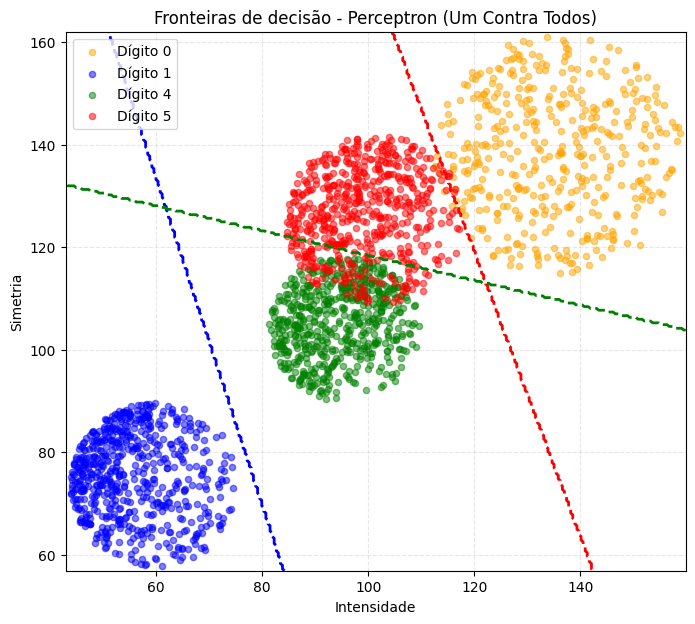

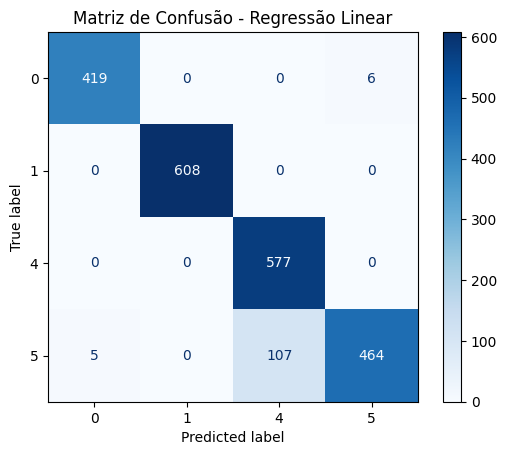

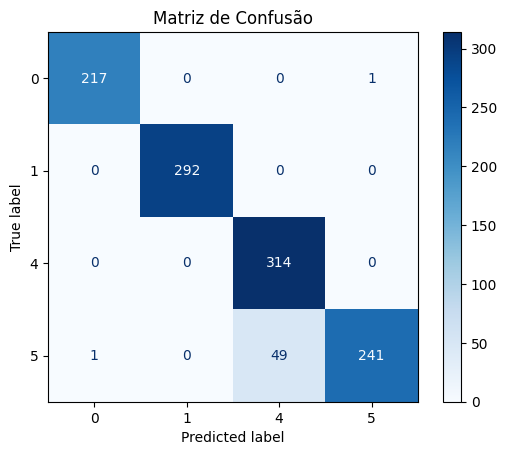

In [26]:
classificadores, previsoes = treinar_um_contra_todos(Perceptron, X_train, y_train, X_test, y_test)
plot_um_contra_todos(classificadores, X_train, y_train)
matriz_confusao(y_test, classificadores)

In [19]:
classificadores, previsoes = treinar_um_contra_todos(Perceptron, X_train, y_train, X_test, y_test)
plot_um_contra_todos(classificadores, X_train, y_train)
avaliar_um_contra_todos(classificadores, X_test, y_test)

TypeError: treinar_um_contra_todos() takes from 3 to 4 positional arguments but 5 were given

#### Regressão Linear

=== Relatório de classificação Linear ===
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.92      0.98      0.95       314
           5       0.84      0.91      0.87       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



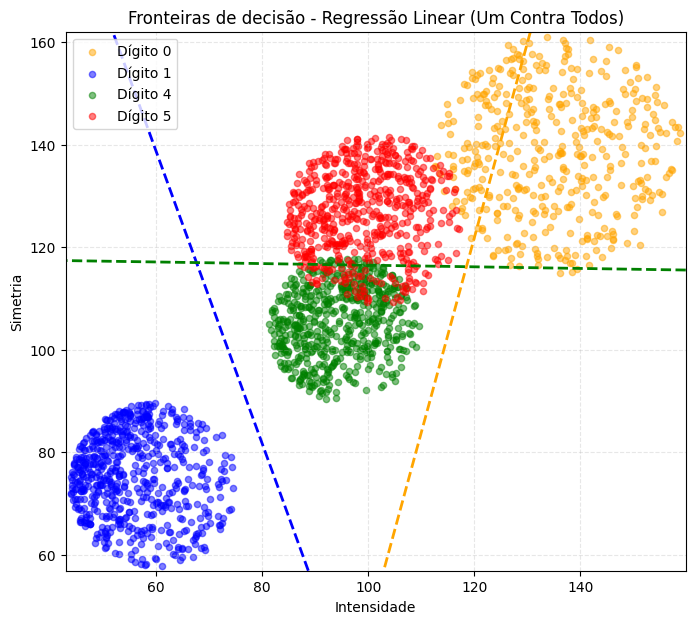

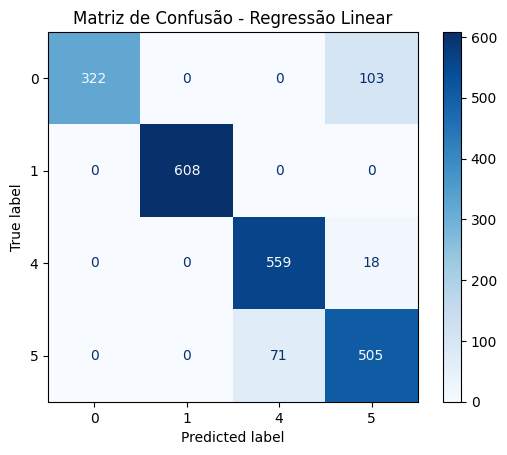

In [ ]:

classificadores_lr, preds_lr = treinar_um_contra_todos_linear(X_train, y_train, X_test, y_test)
plot_um_contra_todos_linear(classificadores_lr, X_train, y_train)

#### Regressão Logística


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.94      0.95      0.94       314
           5       0.94      0.93      0.94       291

    accuracy                           0.97      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.97      0.97      0.97      1115



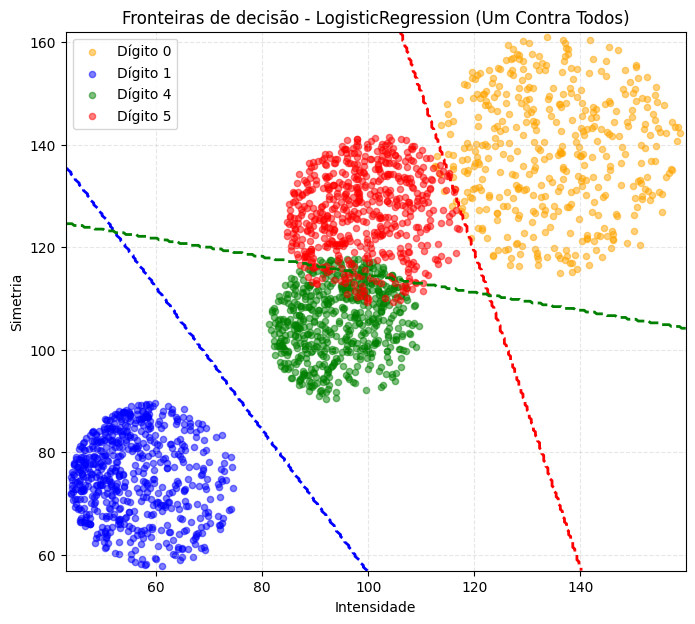

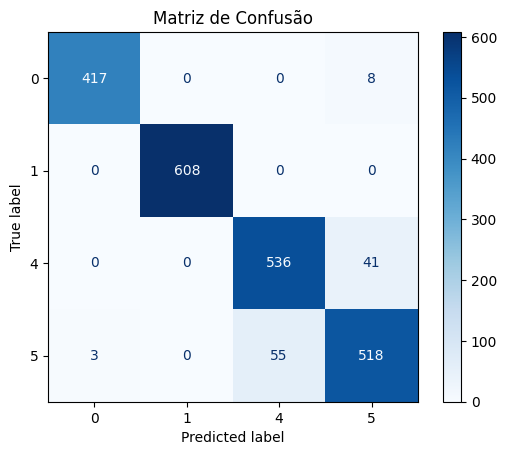

In [ ]:

classificadores, previsoes = treinar_um_contra_todos(LogisticRegression, X_train, y_train, X_test, y_test)
plot_um_contra_todos(classificadores, X_train, y_train)


# 4. Implementações avançadas

## Predição com weight decay

In [ ]:
def treinar_um_contra_todos_logistica_L2(X_train, y_train, X_test, y_test, lambda_=0.01):

    digitos_alvo = [0, 1, 4]
    classificadores = {}

    for idx, digito in enumerate(digitos_alvo):
        # Cria rótulos binários: +1 para alvo, -1 para os outros
        y_bin = np.where(y_train == digito, 1, -1)

        # Remove amostras do dígito anterior 
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        # Escalonamento
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        # Treinar o classificador logístico com L2
        clf = LogisticRegression(
            penalty="l2",
            C=1/lambda_,       
            solver="lbfgs",
            max_iter=1000
        )
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    # Predição sobre os dados de teste
    previsoes = []
    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        if pred is None:
            pred = 5  # fallback caso nenhum classificador responda positivo
        previsoes.append(pred)

    # Relatório de classificação
    print(f"\nRegressão Logística (L2, λ={lambda_})")
    print(classification_report(y_test, previsoes, digits=2))

    return classificadores, previsoes

In [ ]:

# Logística com weight decay
clf_l, preds_l = treinar_um_contra_todos_logistica_L2( X_train, y_train, X_test, y_test)



In [ ]:
# comparando o resultado

classificadores, previsoes = treinar_um_contra_todos(LogisticRegression, X_train, y_train, X_test, y_test)

In [ ]:
plot_um_contra_todos(clf_l, X_train, y_train)

## Melhor ordem de teste

In [ ]:
import itertools

In [ ]:
def melhor_ordem_um_contra_todos(classificador, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4], digito_residual=5):
    melhor_ordem = None
    melhor_acuracia = 0
    melhor_classificadores = None
    melhor_previsoes = None
    
    # Todas as permutações possíveis
    for ordem in itertools.permutations(digitos_alvo):
        # Treina os classificadores nessa ordem
        classificadores = {}
        for idx, digito in enumerate(ordem):
            y_bin = np.where(y_train == digito, 1, -1)
            if idx > 0:
                mask = y_train != ordem[idx - 1]
                X_train_filtrado = X_train[mask]
                y_bin = y_bin[mask]
            else:
                X_train_filtrado = X_train

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_filtrado)

            clf = classificador()
            clf.fit(X_train_scaled, y_bin)
            classificadores[digito] = (clf, scaler)

        # Predição com a lógica da ordem
        previsoes = []
        for x in X_test:
            pred = None
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if clf.predict(x_scaled)[0] == 1:
                    pred = digito
                    break
            if pred is None:
                pred = digito_residual
            previsoes.append(pred)

        acuracia = accuracy_score(y_test, previsoes)
        if acuracia > melhor_acuracia:
            melhor_acuracia = acuracia
            melhor_ordem = ordem
            melhor_classificadores = classificadores
            melhor_previsoes = previsoes

    print(f"Melhor ordem: {melhor_ordem}")
    print(f"Acurácia máxima: {melhor_acuracia:.4f}")
    return melhor_ordem, melhor_classificadores, melhor_previsoes

In [ ]:
def melhor_ordem_linear(X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4], digito_fallback=5):

    from itertools import permutations
    
    melhor_acuracia = -1
    melhor_ordem = None
    melhores_classificadores = None
    melhores_previsoes = None
    
    # Testa todas as permutações possíveis da ordem dos dígitos
    for ordem in permutations(digitos_alvo):
        X_ord = X_train.copy()
        y_ord = y_train.copy()
        classificadores = {}
        
        # Treinamento sequencial
        for idx, digito in enumerate(ordem):
            y_bin = np.where(y_ord == digito, 1, -1)
            
            if idx > 0:
                # Filtra o dígito anterior da mesma forma para X e y
                mask = y_ord != ordem[idx - 1]
                X_ord = X_ord[mask]
                y_ord = y_ord[mask]
                y_bin = y_bin[mask]
            
            # Escalonamento
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_ord)
            
            # Treinamento Linear
            modelo = LinearRegression()
            modelo.fit(X_scaled, y_bin)
            
            classificadores[digito] = (modelo, scaler)
        
        # Predição usando a ordem atual
        previsoes = []
        for x in X_test:
            pred = None
            for digito, (modelo, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if modelo.predict(x_scaled)[0] >= 0:  # limiar 0 para binário
                    pred = digito
                    break
            if pred is None:
                pred = digito_fallback
            previsoes.append(pred)
        
        # Avalia acurácia
        acuracia = np.mean(np.array(previsoes) == y_test)
        
        if acuracia > melhor_acuracia:
            melhor_acuracia = acuracia
            melhor_ordem = ordem
            melhores_classificadores = classificadores
            melhores_previsoes = previsoes
    
    print(f"Melhor ordem encontrada: {melhor_ordem}")
    print(f"Acurácia: {melhor_acuracia:.4f}")


    return melhor_ordem, melhores_classificadores, melhores_previsoes

In [ ]:
melhor_ordem, classificadores, previsoes = melhor_ordem_linear(
    X_train, y_train, X_test, y_test,
    digitos_alvo=[0,1,4],   # dígitos que terão classificador próprio
    digito_fallback=5        # dígito atribuído quando nenhum classificador responde
)

In [ ]:
melhor_ordem, classificadores_otimos, previsoes_otimas = melhor_ordem_um_contra_todos(
    classificador=Perceptron,   
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    digitos_alvo=[0, 1, 4],     
    digito_residual=5             # dígito atribuído quando nenhum classificador responde +1
)

In [ ]:
melhor_ordem, classificadores_otimos, previsoes_otimas = melhor_ordem_um_contra_todos(
    classificador=LogisticRegression,   
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    digitos_alvo=[0, 1, 4],     
    digito_residual=5             # dígito atribuído quando nenhum classificador responde +1
)

# TESTESSSSS